In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster import hierarchy

sns.set()

# ANÁLISE CLAUSTER

### Caso 1 - Considerano a média GERAL

Preparando os dados

In [2]:
dir = 'https://raw.githubusercontent.com/josewilsonsouza/PBAER_UFRJ/main/DADOS_APP/'
df = pd.read_csv(dir+'DADOS_CURSOS.csv')

In [3]:
df_agp = df.loc[:,['CO_CURSO', 'NO_CURSO', 'NU_ANO_CENSO', 'CENTRO','DURACAO','EVASAO','RETENCAO', 'SUCESSO']]

Média geral de `EVASAO`, `RETENCAO` e `SUCESSO` por curso

In [4]:
data = df_agp.loc[:,['CO_CURSO','EVASAO','RETENCAO', 'SUCESSO']].groupby('CO_CURSO').mean()

Alguns Gráficos

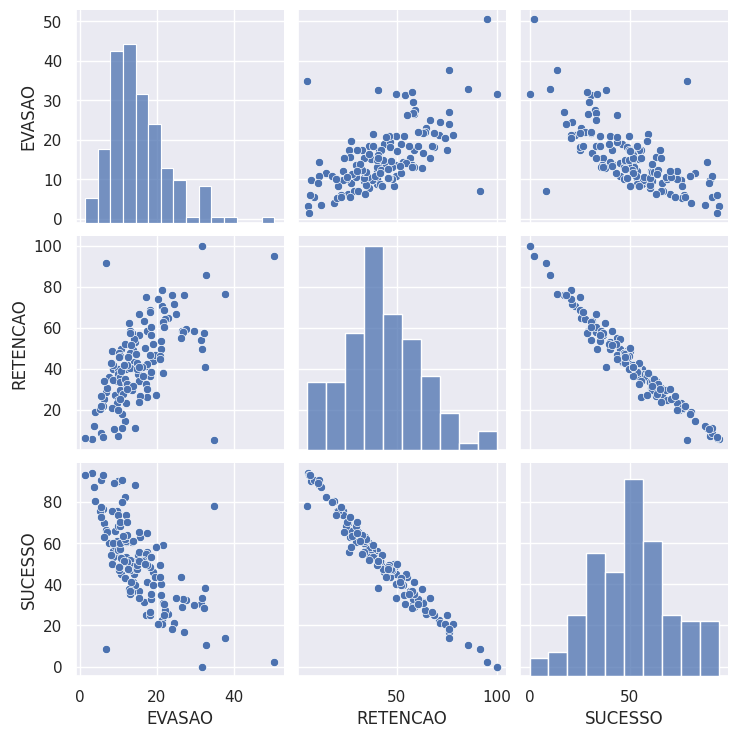

In [7]:
sns.pairplot(data)

<Axes: >

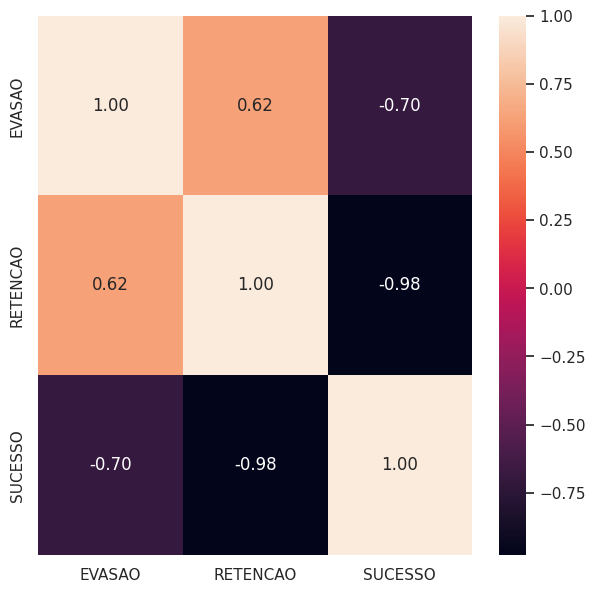

In [5]:
plt.figure(figsize=(7, 7))
corr = np.corrcoef(data.values, rowvar=False)
sns.heatmap(corr, annot=True, fmt='.2f', cbar=True, xticklabels=data.columns, yticklabels=data.columns)

Padronizando os dados

In [9]:
data.iloc[:, :] = StandardScaler().fit_transform(data)

Metodo Hierárquico - Dendrograma

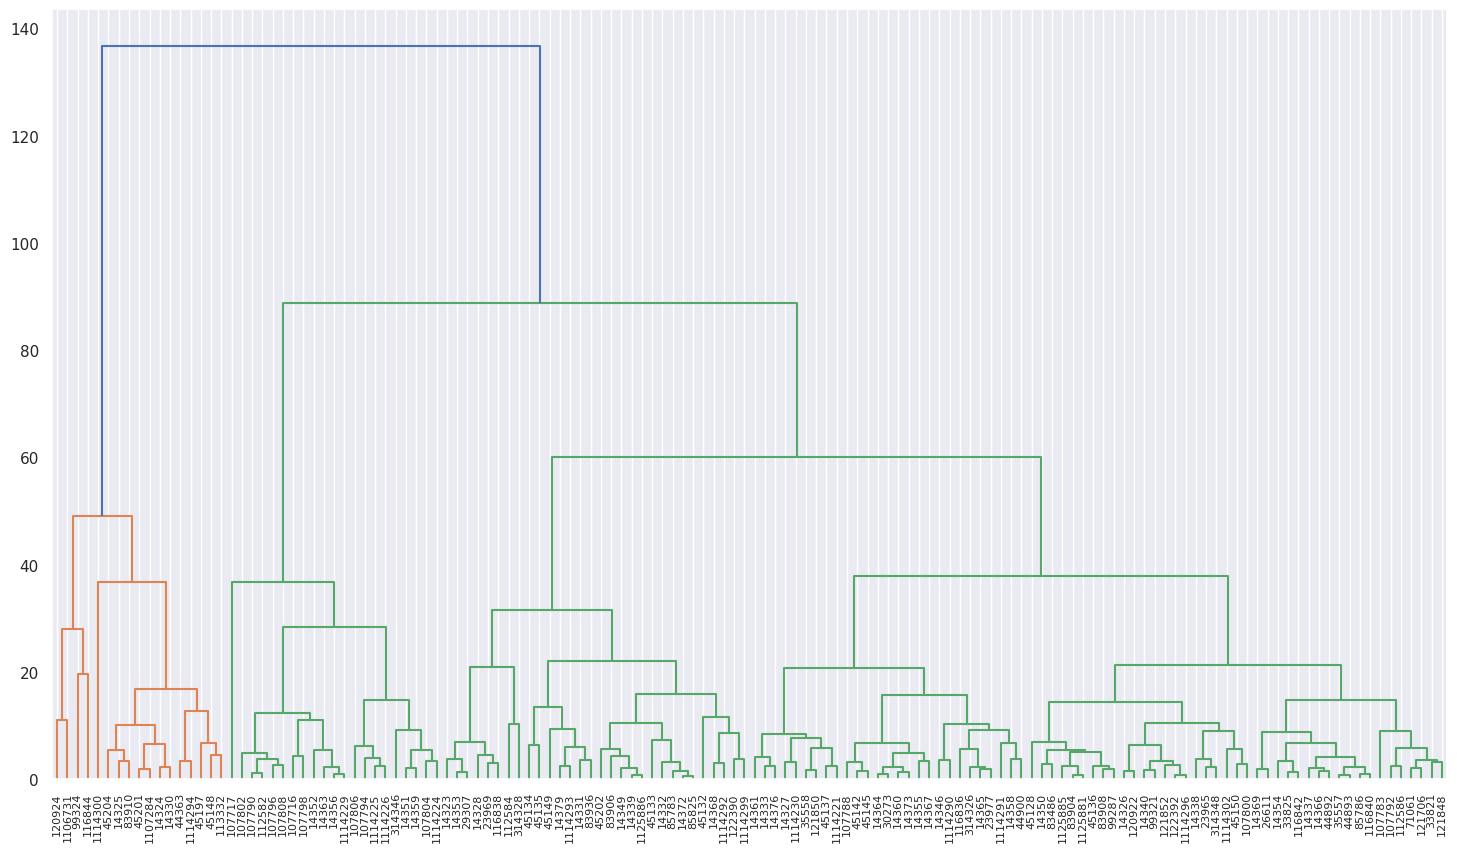

In [6]:
Z = hierarchy.linkage(data, method = 'complete')
plt.figure(figsize=(18, 10))
plt.grid(axis='y')
dn = hierarchy.dendrogram(Z, labels=list(data.index), leaf_font_size=8)

Escolhendo um $k$ apropriado. Prmeiro plotamos o gráfico dos pontos para $k=4$

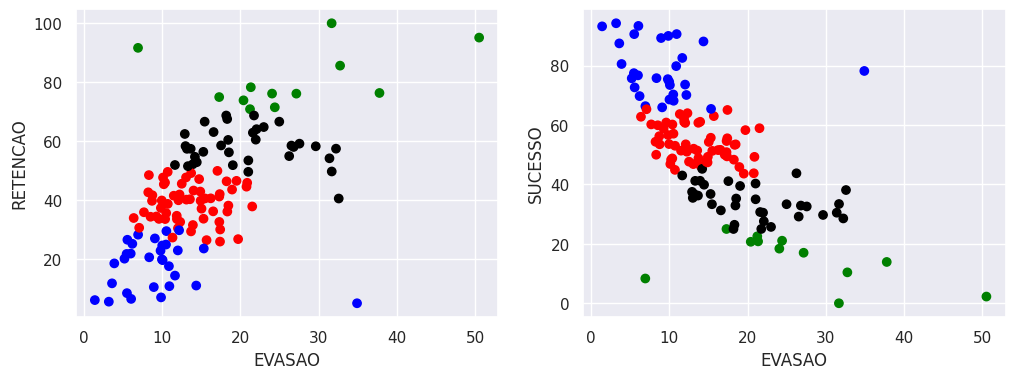

In [7]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
km2 = KMeans(n_clusters=4, random_state = 42, n_init='auto').fit(data)# Testando k = 4
x, y, z = data['EVASAO'], data['RETENCAO'], data['SUCESSO']
cores = ['red', 'green', 'blue', 'black','olive','orange','purple','brown']

ax[0].scatter(x, y, c=[cores[i] for i in km2.labels_])
ax[0].set_xlabel('EVASAO')
ax[0].set_ylabel('RETENCAO')

ax[1].scatter(x, z, c=[cores[i] for i in km2.labels_])
ax[1].set_xlabel('EVASAO')
ax[1].set_ylabel('SUCESSO');

Usando o Método do Cotovelo

In [8]:
inercias = []
kas = []
for i in range(1,16):
  kmeans = KMeans(n_clusters=i,random_state = 0, n_init=10).fit(data)
  kas.append(i)
  inercias.append(kmeans.inertia_)

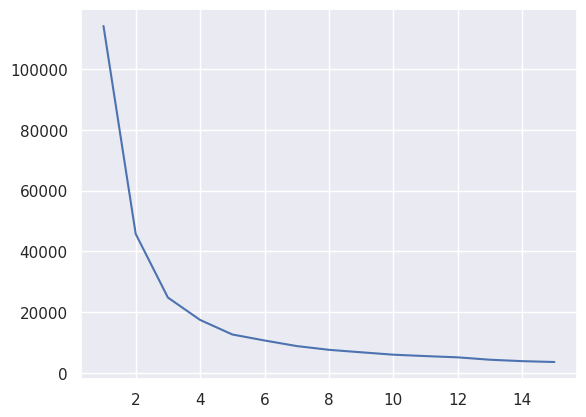

In [9]:
plt.plot(kas, inercias)

Notamos que $k=3$ ou $k=4$ são bons

Agora vamos usar outra medida que pode indicar um bom $k$

In [10]:
from sklearn import metrics

Coeficiente Silhueta

In [11]:
value_k = []
S = []
for k in range(2, 15):
  kmeans = KMeans(n_clusters = k, random_state = 42, n_init=10).fit(data)
  value_k.append(k)
  S.append(metrics.silhouette_score(data, kmeans.labels_))

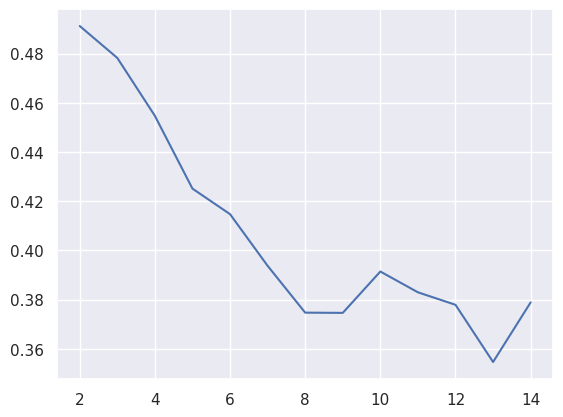

In [12]:
fig, ax = plt.subplots()
ax.plot(value_k, S)

In [13]:
df_geral = data.copy()

In [14]:
k1, k2, k3 = 2, 3, 4
kmeans2, kmeans3, kmeans4 = [KMeans(n_clusters = k1, random_state = 42, n_init=10 ),
                             KMeans(n_clusters = k2, random_state = 42, n_init=10),
                             KMeans(n_clusters = k3, random_state = 42, n_init=10)]

df_geral = df_geral.assign(clusterk2 = kmeans2.fit_predict(data),
                           clusterk3 = kmeans3.fit_predict(data),
                           clusterk4 = kmeans4.fit_predict(data))

df_geral.reset_index(inplace = True)

In [15]:
df_geral = df_geral.merge(df_agp.loc[:,['CO_CURSO','NO_CURSO']].drop_duplicates(keep='first', subset = 'CO_CURSO'), on = 'CO_CURSO', how = 'left' )
df_geral.head()

,CO_CURSO,EVASAO,RETENCAO,SUCESSO,clusterk2,clusterk3,clusterk4,NO_CURSO
0,14323,26.532901,58.571773,29.172224,1,1,3,FISICA
1,14324,22.997411,64.842501,25.694456,1,1,3,ASTRONOMIA
2,14325,21.243704,70.904543,22.536461,1,1,1,METEOROLOGIA
3,14326,14.033681,43.342422,46.104280,1,0,0,GEOGRAFIA
4,14327,6.216665,25.298839,69.740149,0,2,2,GEOLOGIA


$k=4$

In [16]:
grupo0 = df_geral.query('clusterk4 == 0')
grupo1 = df_geral.query('clusterk4 == 1')
grupo2 = df_geral.query('clusterk4 == 2')
grupo3 = df_geral.query('clusterk4 == 3')

In [22]:
len(grupo0), len(grupo1), len(grupo2), len(grupo3)

(59, 12, 30, 35)

### Caso 2 - Considerando cada ano individualmente

In [25]:
cotovelo = {'kas':list(range(1,16))}
vars = ['EVASAO', 'RETENCAO', 'SUCESSO']

for a in range(2015, 2023):
  df_ano = df_agp.loc[df_agp.NU_ANO_CENSO == a].dropna()
  #df_ano.iloc[:, :] = StandardScaler().fit_transform(df_ano)
  inercias = []
  for k in range(1,16): # teste do cotovelo
    kmeans = KMeans(n_clusters = k, random_state=0, n_init=10).fit(df_ano[vars])
    inercias.append(kmeans.inertia_)
  cotovelo[f'inertias{a}'] = inercias

In [26]:
teste_cot = pd.DataFrame(cotovelo)

In [39]:
silhueta = {'kas':list(range(2,16))}

for a in range(2015, 2023):
  df_ano = df_agp.loc[df_agp.NU_ANO_CENSO == a].dropna()
  #df_ano.iloc[:, :] = StandardScaler().fit_transform(df_ano)
  inercias = []
  for k in range(2,16): # teste do cotovelo
    kmeans = KMeans(n_clusters = k, random_state=0, n_init=42).fit(df_ano[vars])
    inercias.append(metrics.silhouette_score(df_ano[vars], kmeans.labels_))
  silhueta[f'score{a}'] = inercias

In [40]:
teste_silhueta = pd.DataFrame(silhueta)

In [41]:
teste_silhueta

,kas,score2015,score2016,score2017,score2018,score2019,score2020,score2021,score2022
0,2,0.548011,0.521930,0.492913,0.544591,0.513963,0.527421,0.529688,0.540410
1,3,0.493468,0.531879,0.501775,0.529908,0.514565,0.500433,0.510197,0.462684
2,4,0.449839,0.463629,0.481390,0.457932,0.514457,0.451064,0.462808,0.467273
3,5,0.448163,0.411709,0.479743,0.459551,0.446122,0.434904,0.459177,0.428031
4,6,0.439460,0.439113,0.457454,0.406427,0.457626,0.445054,0.453476,0.409794
5,7,0.429249,0.422191,0.459658,0.399811,0.434524,0.414275,0.454639,0.391192
6,8,0.429917,0.434328,0.471036,0.390973,0.446895,0.406711,0.419752,0.392716
7,9,0.432385,0.440175,0.458076,0.392656,0.428295,0.438932,0.404284,0.402377
8,10,0.384410,0.441412,0.461383,0.384467,0.435118,0.438821,0.413116,0.382117
9,11,0.388062,0.435771,0.448435,0.407566,0.425546,0.441788,0.415015,0.389117


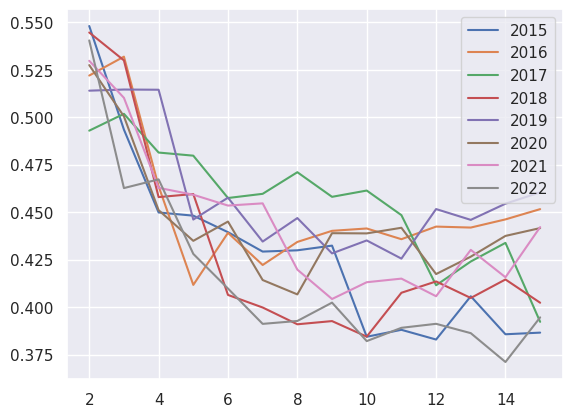

In [42]:
for ano in range(2015,2023):
  plt.plot(range(2,16), teste_silhueta[f'score{ano}'], label = f'{ano}')
  plt.legend()

In [32]:
data.sort_values(by='RETENCAO')

,EVASAO,RETENCAO,SUCESSO
CO_CURSO,,,
107717,34.909833,5.162393,78.200101
14351,3.216855,5.695497,94.262057
14359,1.430432,6.233638,93.216215
1114224,6.064705,6.634850,93.365150
107794,9.884899,7.149810,89.997802
...,...,...,...
45148,21.346154,78.333333,20.833333
1106731,32.746117,85.643090,10.402332
1114300,6.944444,91.666667,8.333333


In [33]:
data.sort_values(by=vars)

,EVASAO,RETENCAO,SUCESSO
CO_CURSO,,,
14359,1.430432,6.233638,93.216215
14351,3.216855,5.695497,94.262057
314346,3.623463,11.909090,87.480507
14352,3.913934,18.663930,80.545182
14363,5.212828,20.258820,75.732330
...,...,...,...
112584,32.571719,40.636941,38.114108
1106731,32.746117,85.643090,10.402332
107717,34.909833,5.162393,78.200101


In [51]:
df15,df16,df17,df18,df19,df20,df21,df22 = [df_agp.query(f'NU_ANO_CENSO == {a}').dropna().reset_index(drop=True) for a in range(2015,2023)]

In [58]:
k = 4
dfs_clts = []
for dfi in [df15,df16,df17,df18,df19,df20,df21,df22]:
  dfi_prev = dfi.loc[:,['CO_CURSO','EVASAO','RETENCAO', 'SUCESSO']].set_index('CO_CURSO')
  kmeans4 = KMeans(n_clusters = k, random_state = 42, n_init=10)
  dfi_prev = dfi_prev.assign(clusterk4 = kmeans4.fit_predict(dfi_prev))
  dfi_prev = dfi_prev.merge(dfi[['CO_CURSO',"NO_CURSO",'NU_ANO_CENSO','DURACAO','CENTRO']], on = 'CO_CURSO', how = 'right')
  dfs_clts.append(dfi_prev)

In [59]:
dfs_clts[0].head()

,CO_CURSO,EVASAO,RETENCAO,SUCESSO,clusterk4,NO_CURSO,NU_ANO_CENSO,DURACAO,CENTRO
0,121706,7.352941,39.248353,48.275862,3,CIÊNCIAS BIOLÓGICAS: BIOFÍSICA,2015,4.0,CAXIAS
1,1114292,22.789116,56.979291,31.182796,3,CIÊNCIAS BIOLÓGICAS: BIOTECNOLOGIA,2015,4.0,CAXIAS
2,1114291,0.000000,46.218487,38.095238,3,NANOTECNOLOGIA,2015,4.0,CAXIAS
3,99287,19.411765,0.000000,100.000000,2,CIÊNCIAS BIOLÓGICAS,2015,5.0,MACAE
4,121848,25.988701,70.187500,22.500000,1,ENFERMAGEM E OBSTETRÍCIA,2015,5.0,MACAE


In [60]:
ds = pd.concat(dfs_clts)

In [70]:
for ano in range(2015,2023):
  for cluster in range(4):
    df_ano = ds.query(f'NU_ANO_CENSO == {ano}')
    df_cluster = df_ano.query(f'clusterk4 == {cluster}')
    print(ano, df_cluster.shape[0], cluster)

2015 25 0
2015 31 1
2015 32 2
2015 41 3
2016 42 0
2016 39 1
2016 19 2
2016 29 3
2017 45 0
2017 14 1
2017 33 2
2017 37 3
2018 30 0
2018 30 1
2018 38 2
2018 25 3
2019 44 0
2019 37 1
2019 31 2
2019 13 3
2020 30 0
2020 35 1
2020 42 2
2020 15 3
2021 31 0
2021 33 1
2021 40 2
2021 18 3
2022 46 0
2022 20 1
2022 36 2
2022 28 3


In [63]:
ds.query(f'CO_CURSO == {14323}')

,CO_CURSO,EVASAO,RETENCAO,SUCESSO,clusterk4,NO_CURSO,NU_ANO_CENSO,DURACAO,CENTRO
64,14323,22.321429,61.450460,30.909091,3,FÍSICA,2015,4.0,CCMN
64,14323,36.206897,46.253230,37.209302,0,FÍSICA,2016,4.0,CCMN
64,14323,21.904762,66.190615,21.276596,3,FÍSICA,2017,4.0,CCMN
64,14323,26.229508,51.080460,38.000000,2,FÍSICA,2018,4.0,CCMN
64,14323,20.175439,59.106933,26.086957,1,FÍSICA,2019,4.0,CCMN
63,14323,20.300752,67.306694,25.531915,0,FÍSICA,2020,4.0,CCMN
64,14323,16.326531,62.044444,28.000000,2,Física,2021,4.0,CCMN
63,14323,20.779221,67.952977,25.581395,0,Física,2022,4.0,CCMN
